## 4장 신경망 학습

In [1]:
# import modules

import numpy as np
import matplotlib.pyplot as plt
from mnist import load_mnist
from PIL import Image
import pickle

In [2]:
# 4.2.1 오차제곱합
def sum_squares_error(y, t):
    return 0.5*np.sum((y-t)**2)

In [3]:
# 4.2.2 CrossEntropy

def cross_entropy_error(y, t):
    delta = 1e-7 # 마이너스 무한대가 되지 않도록 함
    return -np.sum(t*np.log(y+delta))

In [4]:
# 4.2.3 미니배치 학습
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

print(x_train.shape)
print(t_train.shape)


(60000, 784)
(60000, 10)


In [5]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size) # 지정된 범위 수 중 무작위로 수를 꺼냄
x_batch = x_train[batch_mask]
t_batch = t_train[batch_mask]

In [6]:
# 4.2.4 (batch용) cross entropy error 구현


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)

    batch_size = y.shape[0]

    # 정답 레이블이 원핫인코딩이 아닐 때 cross entropy 
    # np.arrange(batch_size)는 0부터 batch_size-1까지 배열을 생성. t에는 label이 저장되어 있다. 
    # y[np.arrange(batch_size), t]는 각 데이터의 정답 레이블에 해당하는 신경망의 출력을 추출한다. y[0,2], y[1,3]과 같이.
    # return -np.sum(np.log(y[np.arrange(batch_size), t]+1e-7)) / batch_size
    
    # 정답 레이블이 원핫인코딩으로 구현되었을 때 cross entropy 구현
    return -np.sum(t*np.log(y+1e-7)) / batch_size



In [7]:
# 4.2.5 왜 손실 함수를 설정하는가? : 정확도를 지표로 하면 매개변수의 미분이 대부분의 장소에서 0이 되기 때문이다. 

In [8]:
# 4.3.1 미분

# 나쁜 구현의 예
def numerical_diff(f, x):
    h = 1e-50 # 반올림 오류 효과가 일어난다.
    return (f(x+h) - f(x)) / h # 근사로 구한 접선이 실제 접선과 일치하지 않는다.

# 개선한 구현
def numerical_diff(f, x):
    h = 1e-4
    return (f(x+h) - f(x-h)) / (2*h)

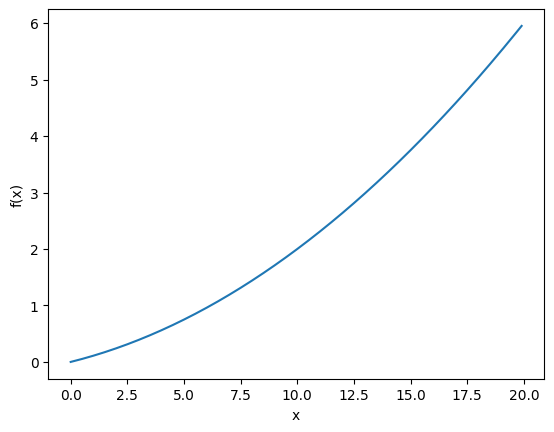

In [9]:
# 4.3.2 수치 미분의 예

def function_1(x):
    return 0.01*x**2 + 0.1*x

x = np.arange(0.0,20.0,0.1)
y = function_1(x)
plt.xlabel("x")
plt.ylabel("f(x)")
plt.plot(x,y)
plt.show()

In [10]:
print(numerical_diff(function_1, 5))
print(numerical_diff(function_1, 10))

0.1999999999990898
0.2999999999986347


0.1999999999990898


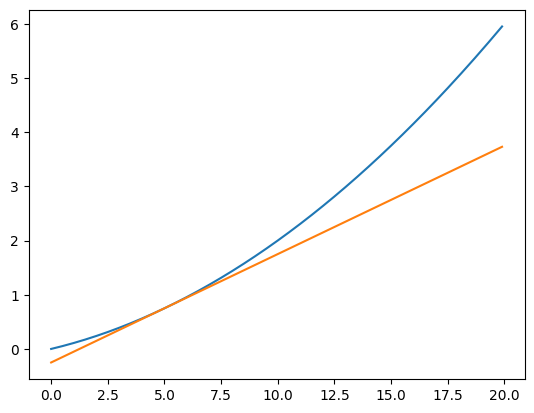

In [11]:
def tangent_line(f, x):
    d = numerical_diff(f, x)
    print(d)
    y = f(x) - d*x
    return lambda t: d*t + y

tf = tangent_line(function_1, 5)
y2 = tf(x)

plt.plot(x, y)
plt.plot(x, y2)
plt.show()

In [12]:
# 4.3.3 편미분

def function_2(x):
    return x[0]**2 + x[1]**2

# x_0=3, x_1=4일때, x_0에 대한 편미분 값을 나타내는 새로운 함수
def function_tmp1(x0):
    return x0*x0 + 4.0**2.0

print(numerical_diff(function_tmp1, 3.0))

# x_0=3, x_1=4일때, x_1에 대한 편미분 값을 나타내는 새로운 함수
def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

print(numerical_diff(function_tmp2, 4.0))

6.00000000000378
7.999999999999119


In [13]:
# 4.4 기울기 (gradient)

def numerical_gradient(f, x):
    h = 1e-4
    grad = np.zeros_like(x)

    for idx in range(x.size):
        tmp_val = x[idx]
        
        # f(x+h) 
        x[idx] = tmp_val + h
        fxh1 = f(x) # 이거를 계산하면, x[idx] 부분에는 f(x[idx]+h)의 결과가 들어가 있는 셈이다.

        # f(x-h)
        x[idx] = tmp_val - h
        fxh2 = f(x) # 이거를 계산하면, x[idx] 부분에는 f(x[idx]-h)의 결과가 들어가 있는 셈이다.

        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val # 값 복원

    return grad

print(numerical_gradient(function_2, np.array([3.0,4.0])))

# 기울기가 가리키는 쪽은 각 장소에서 함수의 출력 값을 가장 크게 줄이는 방향이다!

[6. 8.]


In [14]:
# 4.4.1 경사하강법

def gradient_descent(f, init_x, lr=0.01, step_num=100):
    x = init_x

    for i in range(step_num):
        grad = numerical_gradient(f, x)
        x -= lr * grad
    
    return x

init_x = np.array([-3.0,4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

In [15]:
# 학습률에 따른 차이

init_x = np.array([-3.0,4.0])
print(gradient_descent(function_2, init_x=init_x, lr=10.0, step_num=100))

init_x = np.array([-3.0,4.0])
print(gradient_descent(function_2, init_x=init_x, lr=1e-10, step_num=100))


[-2.58983747e+13 -1.29524862e+12]
[-2.99999994  3.99999992]


In [16]:
# 4.4.2 신경망에서의 기울기
# 코드는 import 부분에서 책의 코드를 살짝 변형했다. 

from functions import softmax, cross_entropy_error
from gradient import numerical_gradient

class simpleNet:
    def __init__(self) -> None:
        self.W = np.random.rand(2,3)

    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)

        return loss

In [17]:
net = simpleNet()
print(net.W)

x = np.array([0.6,0.9])
p = net.predict(x)
print(p)

print(np.argmax(p))

t = np.array([0,0,1])
print(net.loss(x,t))

[[0.65762277 0.30144266 0.08578915]
 [0.94334814 0.19504304 0.43958157]]
[1.24358699 0.35640433 0.4470969 ]
0
1.4185291669281601


In [18]:
def f(W):
    return net.loss(x,t)

dW = numerical_gradient(f, net.W)
print(dW)

[[ 0.32210892  0.13264907 -0.45475799]
 [ 0.48316338  0.19897361 -0.68213699]]


In [19]:
# 4.5.1 2층 신경망 클래스 구현하기

from functions import *
from gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
                 weight_init_std=0.01) -> None:
        self.params = {}
        self.params['W1'] = weight_init_std * \
                            np.random.randn(input_size, hidden_size)
        self.params['b1'] = weight_init_std * \
                            np.random.randn(hidden_size)
        self.params['W2'] = weight_init_std * \
                            np.random.randn(hidden_size, output_size)
        self.params['b2'] = weight_init_std * \
                            np.random.randn(output_size)
        
    def predict(self, x):
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']

        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)

        return y
    
    def loss(self, x, t):
        y = self.predict(x)

        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

        return grads

In [20]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [21]:
# 4.5.2 미니배치 학습 구현하기

from mnist import load_mnist
from two_layer_net import TwoLayerNet

(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)

train_loss_list = []
train_acc_list = []
test_acc_list = []

iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.15

iter_per_epoch = max(train_size/batch_size, 1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.numerical_gradient(x_batch, t_batch)

    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

train acc, test acc | 0.09736666666666667, 0.0982
train acc, test acc | 0.7829833333333334, 0.788
train acc, test acc | 0.8780833333333333, 0.883


KeyboardInterrupt: 

In [ ]:
plt_x = np.arange(0.0, float(len(train_loss_list), 1.0))
plt_y = np.array(train_loss_list)
plt.plot(plt_x, plt_y)
plt.show()

In [ ]:
plt_x = np.arange(0.0, float(len(train_acc_list), 1.0))
plt_y = np.array(train_acc_list)
plt.plot(plt_x, plt_y)
plt.show()

In [ ]:
plt_x = np.arange(0.0, float(len(test_acc_list), 1.0))
plt_y = np.array(test_acc_list)
plt.plot(plt_x, plt_y)
plt.show()